# Checksum Error Detection Probability

In [1]:
P = 0.1
n = 5

In [2]:
import numpy as np
import matplotlib.pyplot as plt

$$ \tag{1}
    f(n, k): \text{chance of } \sum_{i = 0}^{n} \Delta_i = k
$$

$$ \tag{2}
    f(n, k) = \sum_{x = 0}^{2^{16} - 1} P(\Delta_n = x)f(n - 1, k + \bar{x})
$$
where 
$$
    \bar{x} := 
        \begin{cases}
            \bigg(0, 2^{16} - 1\bigg) & x \in \{0, 2^{16} - 1\} \\
            \bigg(2^{16} - 1 - x, \bigg) & \text{o.w.}
        \end{cases}
$$

In [6]:
f = np.zeros((n + 1, 2 ** 16), dtype=np.float64)
f[0] = np.ones(2 ** 16)
f

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
binary = np.fromfunction(lambda x: x, (2 ** 16, ), dtype=np.uint16)
binary_repr = np.vectorize(np.binary_repr, otypes=[str])
binary = np.char.count(binary_repr(binary), '1')
print(binary)
prob = np.array((P ** binary) * ((1-P)**(16 - binary)), dtype=np.float128)
f[1] = prob
f

[ 0  1  1 ... 15 15 16]


array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.85302019e-01, 2.05891132e-02, 2.05891132e-02, ...,
        9.00000000e-16, 9.00000000e-16, 1.00000000e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [8]:
done = np.zeros(n + 1, dtype=np.bool_)
done[0], done[1] = True, True
done

array([ True,  True, False, False, False, False])

In [9]:
np.concatenate([f[0, 1:], f[0, :1]])[:-1].shape

(65535,)

In [10]:
def calc(n):
    if done[n]:
        return
    print(n)
    j = -1
    for i in range(1, int(n / 2)):
        if done[i] and done[n - i]:
            j = i
    if j == -1:
        j = int(n / 2)
        calc(j) ; calc(n - j)
        
    f[n] = np.zeros((2 ** 16))
    for i in range(2 ** 16):
        i_bar = 2 ** 16 - 1 - i
        i_bar_plus = 1 if i_bar == 2 ** 16 - 1 else i_bar + 1
        X = np.concatenate([f[j, i:], f[j, :i]])
        Y = np.concatenate([np.full((i_bar + 1,), f[n - j, i_bar]), np.full((i,), f[n - j, i_bar_plus])])
        
        f[n] += X * Y
        
        if i == 0:
            X = np.concatenate([f[j, i:], f[j, :i]])
            Y = np.concatenate([np.full((2 ** 16,), f[n - j, 0]), np.full((0,), f[n - j, 1])])
            f[n] += X * Y
    done[n] = True
    
calc(n)
f

5
2


3


array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.85302019e-01, 2.05891132e-02, 2.05891132e-02, ...,
        9.00000000e-16, 9.00000000e-16, 1.00000000e-16],
       [3.43368382e-02, 8.17543767e-03, 8.17543767e-03, ...,
        5.78623648e-12, 5.78623648e-12, 1.21439531e-12],
       [6.36268563e-03, 2.47513458e-03, 2.47513458e-03, ...,
        6.04184754e-10, 6.04184754e-10, 1.83697597e-10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.18515993e-04, 1.84712295e-04, 1.84712295e-04, ...,
        8.69529289e-08, 8.69529289e-08, 4.14866164e-08]])

In [14]:
f[n, -1] + f[n, 0] - (1 - P) ** (16 * n)

8.297955786664107e-08

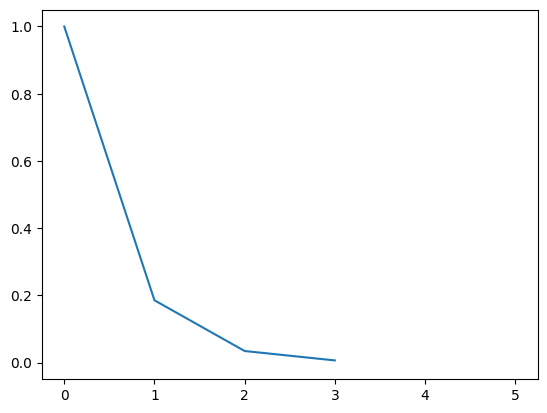

In [12]:
fig, ax = plt.subplots()
Y = f[:, 0]
Y = np.where(Y == 0, None, Y)
ax.plot(Y)
plt.show()

In [13]:
np.sum(f, axis=1)

array([6.55360000e+04, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000004e+00])